In [1]:
from __future__ import print_function

import sys
import os

#sys.path.append('UrbanCNN/');
#sys.path.append('srimmele/');
#sys.path.append('ecbm4040/');
import tensorflow as tf

from matplotlib.pyplot import imshow, plot, title, subplots


from srimmele.data_utils import getCityImages
from UrbanCNN.utils import generator_from_file
import numpy as np

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
city = 'berlin, de'
if not os.path.exists('imagery/' + city):
    getCityImages(city)
else:
    print ('Image files already extracted')

Image files already extracted


[Image augmentation in original paper](https://github.com/adrianalbert/urban-environments/blob/master/land-use-classification/Finetuning%20on%20Urban%20Atlas%20data.ipynb)

In [3]:
all_classes = '''Agricultural + Semi-natural areas + Wetlands
Airports
Construction sites
Continuous Urban Fabric (S.L. > 80%)
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
Fast transit roads and associated land
Forests
Green urban areas
Industrial, commercial, public, military and private units
Isolated Structures
Land without current use
Mineral extraction and dump sites
Other roads and associated land
Port areas
Railways and associated land
Sports and leisure facilities
Water bodies'''.split("\n")

include_classes = ["Green urban areas", 
                       "Airports",
                       "Forests",
                       "Agricultural + Semi-natural areas + Wetlands",
                       # "Railways and associated land",
                       "High Density Urban Fabric", 
                        #"Mineral extraction and dump sites",
                       "Medium Density Urban Fabric", 
                       "Low Density Urban Fabric",
                       "Water bodies",
                       "Sports and leisure facilities",
                       "Industrial, commercial, public, military and private units"]


classes = include_classes
print(len(classes))

class2label = {c:i for i,c in enumerate(classes)}
label2class = {i:c for i,c in enumerate(classes)}
class_weights = {c:1 for c in label2class.keys()}

10


In [ ]:
from keras.preprocessing.image import ImageDataGenerator


#this is the augmentation configuration the author's use for training
train_augmenter = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.10,
        zoom_range=[1,1.2],
        vertical_flip=True,
        rotation_range=15,
        horizontal_flip=True)

test_augmenter = ImageDataGenerator(rescale=1./255)

In [105]:
train_generator      = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                            batch_size = 50, seed=26, new_img_shape= (224,224), \
                            class_dict=class2label, shuffle=True, channels="RGB",
                            downsample=True, crop= 42, batch_type = 'training', one_hot = False)

validation_generator = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                        batch_size = 50, seed=26, new_img_shape= (224,224), \
                        class_dict=class2label, shuffle=True, channels="RGB",
                        downsample=False, crop = 42, batch_type = 'validation', one_hot = False)


19601 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


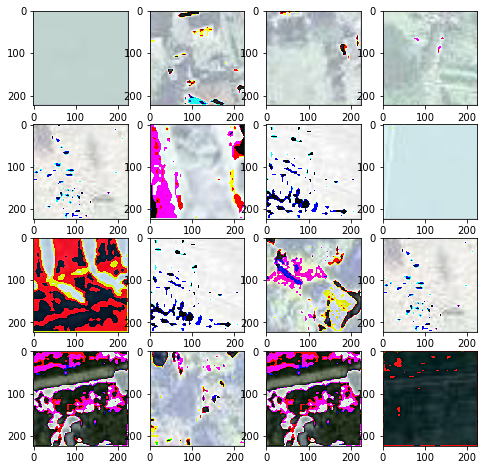

In [5]:
from numpy import random

r = 4
f, axarr = subplots(r, r, figsize=(8,8))
test = next(train_generator)

for i in range(r):
    for j in range(r):

        img = test[0][random.randint(0,50),:,:,:] 
        axarr[i][j].imshow(img)
        #title(label2class[test[1][0]])


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


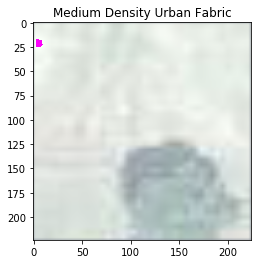

In [6]:
## construction sites are largely inaccurate

test = next(train_generator)
image =imshow(test[0][0,:,:,:])
test[1][0]
title(label2class[test[1][0]])


2827 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


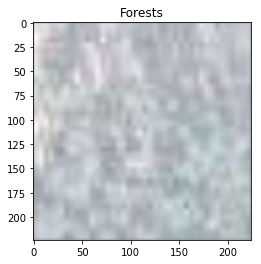

In [7]:
test = next(validation_generator)
image =imshow(test[0][1,:,:,:])
title(label2class[test[1][1]])


## Reference Model:

Albert et. al used a standard VGG16 architecture with the following settings:

* Optimizer: AdaDelta
    * Learning Rate: 0.1
    * Learning Rate Decay: 1/2 every 10 epochs
* Dropout on Fully Connected Layers: 50%
* Mini-batch Size: 100
* Penalty Term: None
* Epochs: varying 10-100
    * samples per epoch: 2000
    
 
This model is reproduced below. **Because of memory constraints, the mini-batch size had to be reduced to 50 from 100 images at full resolution.**


### Not shown:
* The model was run for 40 epochs as well, with no significant change after 20 epochs. 
    

In [67]:
conv_feat_dict = {}

conv_feat_dict[0] = [64 , 64]
conv_feat_dict[1] = [128 , 128]
conv_feat_dict[2] = [256 ,256, 256]
conv_feat_dict[3] = [512 , 512, 512]
conv_feat_dict[4] = [512 , 512, 512]

conv_kernel_dict = dict(keys = conv_feat_dict.keys())

conv_kernel_dict[0] = [3] * 2
conv_kernel_dict[1] = [3] * 2
conv_kernel_dict[2] = [3] * 3
conv_kernel_dict[3] = [3] * 3
conv_kernel_dict[4] = [3] * 3

pooling_size_dict = dict(keys = conv_feat_dict.keys())

pooling_size_dict[0] = [2] * 2
pooling_size_dict[1] = [2] * 2
pooling_size_dict[2] = [2] * 3
pooling_size_dict[3] = [2] * 3 
pooling_size_dict[4] = [2] * 3

fc_units = [4096, 4096]


In [79]:
from srimmele.classifiers import training

tf.reset_default_graph()

training(train_generator, validation_generator,
             conv_feat_dict = conv_feat_dict,
             fc_units = fc_units,
             conv_kernel_dict = conv_kernel_dict,
             pooling_size_dict = pooling_size_dict,
             img_size = 224,
             l2_norm= 0,
             seed = 422,
             batch_size = 50,
             learning_rate= .1,
             lr_decay = 2,
             dropout_keep = 0.5, 
             epoch=20,
             samples_per_epoch = 2000,
             verbose = False,
             pre_trained_model=None,
             model_name='VGG16_Albert')

epoch 1 


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Best validation accuracy! iteration:10 accuracy: 0.09999999403953552%
Best validation accuracy! iteration:30 accuracy: 0.11999999731779099%
Best validation accuracy! iteration:40 accuracy: 0.14000000059604645%
epoch 2 
Best validation accuracy! iteration:70 accuracy: 0.2199999839067459%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:170 accuracy: 0.2199999988079071%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
New learning rate: 0.05
epoch 12 
Best validation accuracy! iteration:450 accuracy: 0.23999999463558197%
Best validation accuracy! iteration:470 accuracy: 0.3199999928474426%
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
End. The best validation accuracy is 0.3199999928474426. Model named VGG16_Albert_1513550345.


## Notes:

Keras Convolution2d defaults:
* padding = 'valid' , but author adds 0padding layer to compensate. 
* bias initialized to 0
* glorot uniform kernel init

VGG16 pretrain: 
http://www.cs.toronto.edu/~frossard/post/vgg16/

see here for weights and code


### Attempted parameter tuning
* learning rate vary from .1 (paper) down to 1e-4 (original VGG16)
* LR Decay from 2-10
* Penalty from 0 to 5e-2 (original VGG)
* Kernel size 2 and 3
* batch size 50-100 , 100 (paper batch count) maxes out memory
* Crop image following paper specs vs. original image.
* Adadelta and Adam optimizers



## Testing the reproduced model 

The image generator for the test set iterates through the testset sequentially rather than shuffling randomly. 

Reading ids 0 -- 50


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


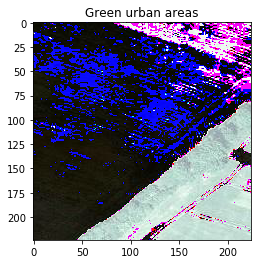

In [81]:
test_generator = generator_from_file('data/test.csv', image_generator= None, balance=1, \
                        batch_size = 50, seed=26, new_img_shape= (224,224), \
                        class_dict=None, shuffle=False, channels="RGB",
                        downsample=False, crop = None, batch_type = None, one_hot = False)

test_set = next(test_generator)
image =imshow(test_set[0][1,:,:,:])
title(label2class[test_set[1][1]])

In [100]:
def calculate_stats(generator , model, iters):
    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('model/' + model + '.meta')
        saver.restore(sess, tf.train.latest_checkpoint('model/'))

        graph = tf.get_default_graph()

        tf_input = graph.get_operations()[0].name+":0"
        x = graph.get_tensor_by_name(tf_input)
        print(x)

        tf_output = "fc_layer_2/Add:0"
        y = graph.get_tensor_by_name(tf_output)
        print(y)


        preds    = np.empty((0,))
        labels   = np.empty((0,))
        accuracy = np.empty((0,))
        for i in range(iters):
            test_set = next(generator)
            X_test =  test_set[0]

            prediction=tf.argmax(y,1)
            y_out = prediction.eval(feed_dict={x: X_test  })

            labels = np.append(labels,test_set[1], axis = 0)
            preds  = np.append(preds, y_out, axis = 0)
            accuracy = np.append(accuracy,(y_out == test_set[1]), axis = 0)
            
    return labels, preds, accuracy

model1_accuracy.mean()

In [102]:

model1_labels , model1_preds, model1_accuracy = calculate_stats(test_generator,\
                                                'VGG16_Albert_1513550345',
                                                iters = 50)

INFO:tensorflow:Restoring parameters from model/VGG16_Albert_1513550345
Tensor("inputs/Placeholder:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("fc_layer_2/Add:0", shape=(?, 10), dtype=float32)


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

In [103]:
model1_accuracy.mean()

0.33818181818181819

In [106]:
## Getting the training error on a decent sample of the training set

_ , _ , model1_Train_accuracy = calculate_stats(train_generator,
                                                'VGG16_Albert_1513550345',
                                                iters = 50)

INFO:tensorflow:Restoring parameters from model/VGG16_Albert_1513550345
Tensor("inputs/Placeholder:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("fc_layer_2/Add:0", shape=(?, 10), dtype=float32)
19601 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [108]:
model1_Train_accuracy.mean()

0.38879999999999998

In [91]:
from pandas import Series, DataFrame
from sklearn.metrics import confusion_matrix

class_preds = Series(model1_preds).map(label2class)
class_labels = Series(model1_labels).map(label2class)

### Actual Class Labels in Test Set

Note: there are no labels of type *Industrial, commercial, public, military and private units* in the set.


In [92]:
class_labels.value_counts()

High Density Urban Fabric                       1999
Green urban areas                               1661
Water bodies                                    1139
Low Density Urban Fabric                         401
Medium Density Urban Fabric                      108
Forests                                           72
Airports                                          65
Agricultural + Semi-natural areas + Wetlands      38
Sports and leisure facilities                     17
dtype: int64

In [90]:
DataFrame(confusion_matrix(list(model1_preds),list(model1_labels)), index=classes[:9], columns=classes[:9])

,Green urban areas,Airports,Forests,Agricultural + Semi-natural areas + Wetlands,High Density Urban Fabric,Medium Density Urban Fabric,Low Density Urban Fabric,Water bodies,Sports and leisure facilities
Green urban areas,0,0,0,0,0,0,0,0,0
Airports,200,20,6,0,28,4,5,3,0
Forests,0,0,0,0,0,0,0,0,0
Agricultural + Semi-natural areas + Wetlands,506,8,33,1,4,0,5,2,0
High Density Urban Fabric,456,25,19,27,1769,93,231,913,16
Medium Density Urban Fabric,199,6,7,5,144,5,95,157,1
Low Density Urban Fabric,300,6,7,5,54,6,65,64,0
Water bodies,0,0,0,0,0,0,0,0,0
Sports and leisure facilities,0,0,0,0,0,0,0,0,0


## Transfer Learning

In [115]:
## Reinstantiate the generators.
## Had to lower batch size to 40 to avoid OOM Error.

train_generator      = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                            batch_size = 40, seed=26, new_img_shape= (224,224), \
                            class_dict=class2label, shuffle=True, channels="RGB",
                            downsample=True, crop= 42, batch_type = 'training', one_hot = False)

validation_generator = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                        batch_size = 40, seed=26, new_img_shape= (224,224), \
                        class_dict=class2label, shuffle=True, channels="RGB",
                        downsample=False, crop = 42, batch_type = 'validation', one_hot = False)


In [116]:
tf.reset_default_graph()

training(train_generator, validation_generator,
             conv_feat_dict = conv_feat_dict,
             fc_units = fc_units,
             conv_kernel_dict = conv_kernel_dict,
             pooling_size_dict = pooling_size_dict,
             img_size = 224,
             l2_norm= 0,
             seed = 422,
             batch_size = 50,
             learning_rate= .1,
             lr_decay = 2,
             dropout_keep = 0.5, 
             epoch=20,
             samples_per_epoch = 2000,
             verbose = False,
             pre_trained_model=None,
             useImageNet = True,
             model_name='VGG16_ImageNet')



assigned ImageNet weights to: conv_layer_3/conv_bias/conv_bias_3
assigned ImageNet weights to: conv_layer_4/conv_bias/conv_bias_4
assigned ImageNet weights to: conv_layer_3/conv_kernel_3
assigned ImageNet weights to: conv_layer_16/conv_kernel_16
assigned ImageNet weights to: conv_layer_7/conv_bias/conv_bias_7
assigned ImageNet weights to: conv_layer_12/conv_bias/conv_bias_12
assigned ImageNet weights to: conv_layer_14/conv_kernel_14
assigned ImageNet weights to: conv_layer_6/conv_bias/conv_bias_6
assigned ImageNet weights to: conv_layer_1/conv_kernel_1
assigned ImageNet weights to: conv_layer_6/conv_kernel_6
assigned ImageNet weights to: conv_layer_1/conv_bias/conv_bias_1
assigned ImageNet weights to: conv_layer_4/conv_kernel_4
assigned ImageNet weights to: conv_layer_0/conv_bias/conv_bias_0
assigned ImageNet weights to: conv_layer_0/conv_kernel_0
assigned ImageNet weights to: conv_layer_12/conv_kernel_12
assigned ImageNet weights to: conv_layer_15/conv_bias/conv_bias_15
assigned Image

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2827 total records
Best validation accuracy! iteration:10 accuracy: 0.15000000596046448%
Best validation accuracy! iteration:30 accuracy: 0.17500001192092896%
epoch 2 
Best validation accuracy! iteration:60 accuracy: 0.32500001788139343%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
New learning rate: 0.05
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
End. The best validation accuracy is 0.32500001788139343. Model named VGG16_ImageNet_1513555215.


In [119]:
test_generator = generator_from_file('data/test.csv', image_generator= None, balance=1, \
                        batch_size = 50, seed=26, new_img_shape= (224,224), \
                        class_dict=None, shuffle=False, channels="RGB",
                        downsample=False, crop = None, batch_type = None, one_hot = False)


model2_labels , model2_preds, model2_accuracy = calculate_stats(test_generator,\
                                                'VGG16_ImageNet_1513555215',
                                                iters = 100)

INFO:tensorflow:Restoring parameters from model/VGG16_ImageNet_1513555215
Tensor("inputs/Placeholder:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("fc_layer_2/Add:0", shape=(?, 10), dtype=float32)
Reading ids 0 -- 50


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Reading ids 50 -- 100
Reading ids 100 -- 150
Reading ids 150 -- 200
Reading ids 200 -- 250
Reading ids 250 -- 300
Reading ids 300 -- 350
Reading ids 350 -- 400
Reading ids 400 -- 450
Reading ids 450 -- 500
Reading ids 500 -- 550
Reading ids 550 -- 600
Reading ids 600 -- 650
Reading ids 650 -- 700
Reading ids 700 -- 750
Reading ids 750 -- 800
Reading ids 800 -- 850
Reading ids 850 -- 900
Reading ids 900 -- 950
Reading ids 950 -- 1000
Reading ids 1000 -- 1050
Reading ids 1050 -- 1100
Reading ids 1100 -- 1150
Reading ids 1150 -- 1200
Reading ids 1200 -- 1250
Reading ids 1250 -- 1300
Reading ids 1300 -- 1350
Reading ids 1350 -- 1400
Reading ids 1400 -- 1450
Reading ids 1450 -- 1500
Reading ids 1500 -- 1550
Reading ids 1550 -- 1600
Reading ids 1600 -- 1650
Reading ids 1650 -- 1700
Reading ids 1700 -- 1750
Reading ids 1750 -- 1800
Reading ids 1800 -- 1850
Reading ids 1850 -- 1900
Reading ids 1900 -- 1950
Reading ids 1950 -- 2000
Reading ids 2000 -- 2050
Reading ids 2050 -- 2100
Reading ids 2

In [120]:
model2_accuracy.mean()

0.12659999999999999

In [121]:
## Reinstantiate the generators.

train_generator      = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                            batch_size = 100, seed=26, new_img_shape= (112,112), \
                            class_dict=class2label, shuffle=True, channels="RGB",
                            downsample=True, crop= None, batch_type = 'training', one_hot = False)

validation_generator = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                        batch_size = 100, seed=26, new_img_shape= (112,112), \
                        class_dict=class2label, shuffle=True, channels="RGB",
                        downsample=False, crop = None, batch_type = 'validation', one_hot = False)


In [ ]:
tf.reset_default_graph()

training(train_generator, validation_generator,
             conv_feat_dict = conv_feat_dict,
             fc_units = fc_units,
             conv_kernel_dict = conv_kernel_dict,
             pooling_size_dict = pooling_size_dict,
             img_size = 112,
             l2_norm= 5e-2,
             seed = 422,
             batch_size = 100,
             learning_rate= .1,
             lr_decay = 1.2,
             dropout_keep = 0.5, 
             epoch=30,
             samples_per_epoch = 2000,
             verbose = False,
             pre_trained_model=None,
             useImageNet = True,
             model_name='VGG16_Regularized')



assigned ImageNet weights to: conv_layer_3/conv_bias/conv_bias_3
assigned ImageNet weights to: conv_layer_4/conv_bias/conv_bias_4
assigned ImageNet weights to: conv_layer_3/conv_kernel_3
assigned ImageNet weights to: conv_layer_16/conv_kernel_16
assigned ImageNet weights to: conv_layer_7/conv_bias/conv_bias_7
assigned ImageNet weights to: conv_layer_12/conv_bias/conv_bias_12
assigned ImageNet weights to: conv_layer_14/conv_kernel_14
assigned ImageNet weights to: conv_layer_6/conv_bias/conv_bias_6
assigned ImageNet weights to: conv_layer_1/conv_kernel_1
assigned ImageNet weights to: conv_layer_6/conv_kernel_6
assigned ImageNet weights to: conv_layer_1/conv_bias/conv_bias_1
assigned ImageNet weights to: conv_layer_4/conv_kernel_4
assigned ImageNet weights to: conv_layer_0/conv_bias/conv_bias_0
assigned ImageNet weights to: conv_layer_0/conv_kernel_0
assigned ImageNet weights to: conv_layer_12/conv_kernel_12
assigned ImageNet weights to: conv_layer_15/conv_bias/conv_bias_15
assigned Image

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2827 total records
Best validation accuracy! iteration:10 accuracy: 0.14000000059604645%
Best validation accuracy! iteration:20 accuracy: 0.1899999976158142%
epoch 2 
epoch 3 
Best validation accuracy! iteration:60 accuracy: 0.2199999988079071%
epoch 4 
epoch 5 
Best validation accuracy! iteration:90 accuracy: 0.22999998927116394%
epoch 6 
epoch 7 
Best validation accuracy! iteration:130 accuracy: 0.29999998211860657%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
New learning rate: 0.08333333333333334
Best validation accuracy! iteration:220 accuracy: 0.3199999928474426%
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
